In [ ]:
# Include in Colab or local Python environment
!pip install ccxt web3 pandas

try:
    import ccxt  # Binance API wrapper
except ImportError as e:
    raise ImportError("ccxt library not found. Please ensure it is installed.") from e

try:
    from web3 import Web3  # Web3 for interacting with Uniswap
except ImportError as e:
    raise ImportError("web3 library not found. Please ensure it is installed.") from e

import time
import numpy as np
import pandas as pd

# Configuration settings
BINANCE_API_KEY = 'your_binance_api_key'
BINANCE_SECRET_KEY = 'your_binance_secret_key'
UNISWAP_V2_URL = 'https://mainnet.infura.io/v3/your_project_id'
POOL_ADDRESS = 'uniswap_eth_usdc_pool_address'  # Example address

# Initialize connections
binance = None
try:
    binance = ccxt.binance({
        'apiKey': BINANCE_API_KEY,
        'secret': BINANCE_SECRET_KEY,
    })
except Exception as e:
    print("Error initializing Binance connection:", str(e))

web3 = Web3(Web3.HTTPProvider(UNISWAP_V2_URL))

# Constants
HEDGE_REBALANCE_THRESHOLD = 0.02  # 2% price movement
FUNDING_RATE_UPDATE_INTERVAL = 60  # seconds

# Helper functions
def get_uniswap_price():
    """Fetch ETH/USDC price from Uniswap V2."""
    # Simulate fetching price using web3 for simplicity
    try:
        eth_reserve = web3.eth.get_storage_at(POOL_ADDRESS, 1)  # Placeholder
        usdc_reserve = web3.eth.get_storage_at(POOL_ADDRESS, 2)  # Placeholder
        eth_price = int(usdc_reserve) / int(eth_reserve)  # Uniswap price formula
        return eth_price
    except Exception as e:
        print("Error fetching Uniswap price:", str(e))
        return 0


def get_binance_futures_price():
    """Fetch ETH/USDT perpetual futures price from Binance."""
    if binance:
        try:
            ticker = binance.fetch_ticker('ETH/USDT')
            return ticker['last']
        except Exception as e:
            print("Error fetching Binance futures price:", str(e))
    return 0


def compute_delta(lp_eth, lp_usdc, eth_price):
    """Compute delta exposure for impermanent loss hedging."""
    total_value = lp_eth * eth_price + lp_usdc
    target_usdc = total_value / 2
    target_eth = target_usdc / eth_price
    delta_eth = target_eth - lp_eth
    return delta_eth

cumulative_position = 0  # Track cumulative hedge positions

def hedge_position(delta_eth, eth_futures_price):
    """Hedge using Binance futures to offset delta exposure."""
    global cumulative_position
    position_size = delta_eth - cumulative_position
    if abs(position_size) > 0.001:  # Minimal trade size to avoid overtrading
        if binance:
            try:
                side = 'buy' if position_size > 0 else 'sell'
                order_type = 'market'
                binance.create_order('ETH/USDT', 'future', order_type, side, abs(position_size))
                cumulative_position += position_size  # Update cumulative position
                print(f"Hedged {side} {abs(position_size)} ETH at price {eth_futures_price}")
            except Exception as e:
                print("Error placing hedge order:", str(e))


# Simulation of strategy
lp_eth = 10  # Example starting LP token split
lp_usdc = 20000

# Backtesting data setup
historical_data = pd.DataFrame({
    'eth_price': [2000, 2100, 2200, 2100, 2050, 2150, 2000],
    'futures_price': [2005, 2105, 2210, 2095, 2040, 2160, 1990]
})

backtest_results = []

for index, row in historical_data.iterrows():
    eth_price = row['eth_price']
    futures_price = row['futures_price']
    delta_eth = compute_delta(lp_eth, lp_usdc, eth_price)

    if abs(delta_eth - cumulative_position) > HEDGE_REBALANCE_THRESHOLD:
        hedge_position(delta_eth, futures_price)
        result = {
            'eth_price': eth_price,
            'futures_price': futures_price,
            'delta_eth': delta_eth,
            'cumulative_hedged_position': cumulative_position
        }
    else:
        result = {
            'eth_price': eth_price,
            'futures_price': futures_price,
            'delta_eth': delta_eth,
            'cumulative_hedged_position': cumulative_position
        }
    backtest_results.append(result)

# Display backtest results
backtest_df = pd.DataFrame(backtest_results)
print("\nBacktest Results:\n", backtest_df)



Error placing hedge order: binance GET https://api.binance.com/sapi/v1/capital/config/getall?timestamp=1736893281578&recvWindow=10000&signature=aa91926b2bc8c80de32fa2f8ec9d1b30e902b0ffdb9da8a549f6c871c9bf6771 451  {
  "code": 0,
  "msg": "Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."
}
Error placing hedge order: binance GET https://api.binance.com/sapi/v1/capital/config/getall?timestamp=1736893281688&recvWindow=10000&signature=ace6cac5351e423b63f0b61c3ebbcef4a0181fee5e2d484a472bac228166bdb0 451  {
  "code": 0,
  "msg": "Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."
}
Error placing hedge order: binance GET https://api.binance.com/sapi/v1/capital/config/getall?timestamp=1736893281738&recvW

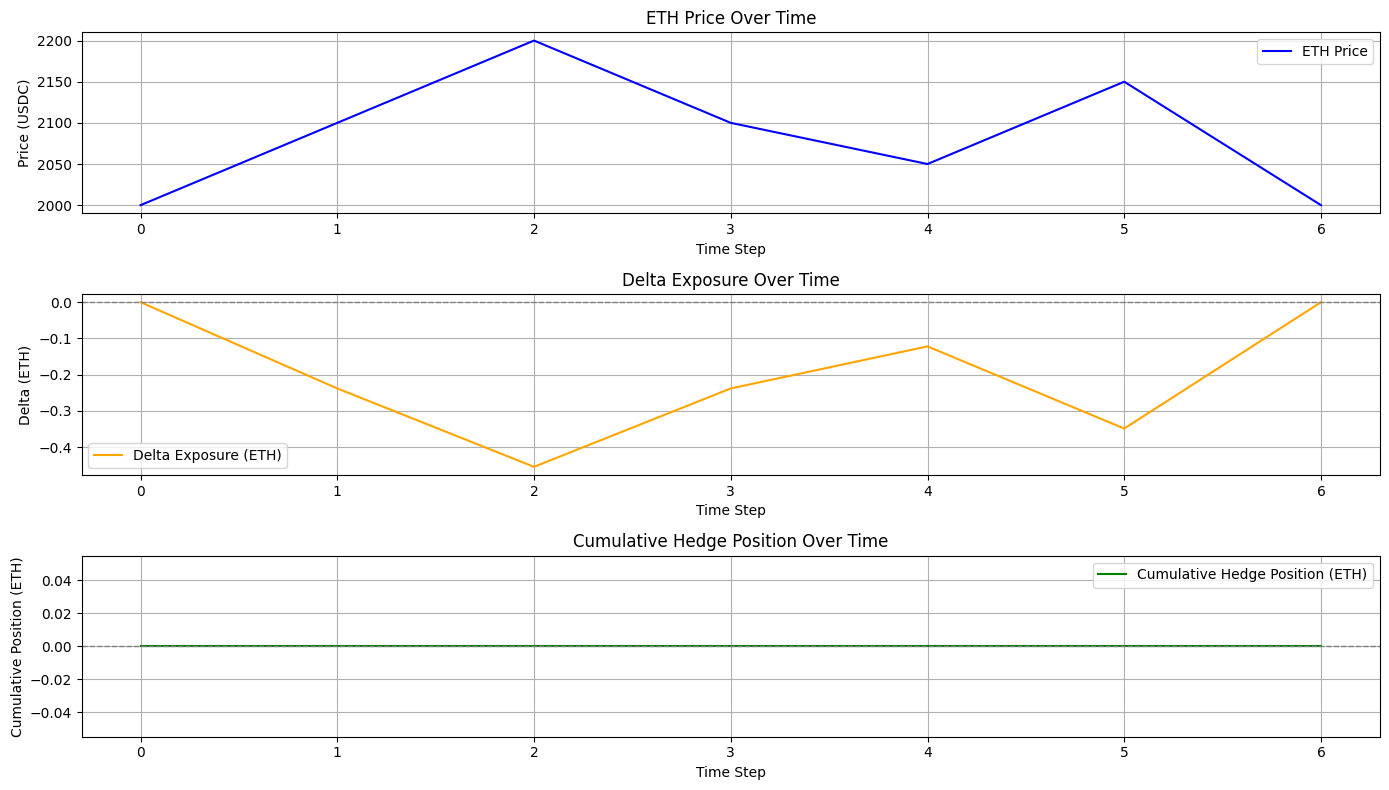

In [ ]:
import matplotlib.pyplot as plt

# Backtest Results Visualization
plt.figure(figsize=(14, 8))

# Plot ETH Price
plt.subplot(3, 1, 1)
plt.plot(backtest_df.index, backtest_df['eth_price'], label='ETH Price', color='blue')
plt.title('ETH Price Over Time')
plt.xlabel('Time Step')
plt.ylabel('Price (USDC)')
plt.legend()
plt.grid()

# Plot Delta Exposure
plt.subplot(3, 1, 2)
plt.plot(backtest_df.index, backtest_df['delta_eth'], label='Delta Exposure (ETH)', color='orange')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Delta Exposure Over Time')
plt.xlabel('Time Step')
plt.ylabel('Delta (ETH)')
plt.legend()
plt.grid()

# Plot Cumulative Hedged Position
plt.subplot(3, 1, 3)
plt.plot(backtest_df.index, backtest_df['cumulative_hedged_position'], label='Cumulative Hedge Position (ETH)', color='green')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Cumulative Hedge Position Over Time')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Position (ETH)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
